In [65]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [66]:
import joblib
import numpy as np
import pandas as pd
import warnings
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Flatten, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# Adjusting warnings
warnings.filterwarnings('ignore')

In [67]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,name_length,last_letter,last_two_letters,first_letter,first_two_letters
0,ابتسام,0,6,م,ام,ا,اب
1,ابتهاج,0,6,ج,اج,ا,اب
2,ابتهال,0,6,ل,ال,ا,اب
3,اجتهاد,0,6,د,اد,ا,اج
4,ازدهار,0,6,ر,ار,ا,از


In [68]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

# Tokenizing and padding the 'name' column for LSTM input
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)  # char_level=True for character tokenization
tokenizer.fit_on_texts(df['name'])
sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [69]:
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

max_unicode_value_first = np.max(first_letter_encoded)
max_unicode_value_last = np.max(last_letter_encoded)
max_unicode_value = max(max_unicode_value_first, max_unicode_value_last)

In [70]:
# Load the scaler models
scaler_first = joblib.load('saved_models/scaler_models/scaler_first_letter.pkl')
scaler_last = joblib.load('saved_models/scaler_models/scaler_last_letter.pkl')

# Transform the new data using the loaded scalers
first_letter_encoded_scaled = scaler_first.transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler_last.transform(last_letter_encoded.reshape(-1, 1))

In [71]:
y = df['sex'].values
X = list(zip(padded_sequences, first_letter_encoded_scaled, last_letter_encoded_scaled))

# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1


# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

train_size_percentage = 1 - total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the number of samples in the training, validation, and test sets
print(f"Training set size: {len(X_train)}, Labels: {len(y_train)}")
print(f"Validation set size: {len(X_val)}, Labels: {len(y_val)}")
print(f"Test set size: {len(X_test)}, Labels: {len(y_test)}")

# Unpack the training data into separate arrays for each input
name_train, first_letter_train, last_letter_train = zip(*X_train)
name_val, first_letter_val, last_letter_val = zip(*X_val)
name_test, first_letter_test, last_letter_test = zip(*X_test)

# Convert tuples to numpy arrays
name_train = np.array(name_train)
first_letter_train = np.array(first_letter_train)
last_letter_train = np.array(last_letter_train)

name_val = np.array(name_val)
first_letter_val = np.array(first_letter_val)
last_letter_val = np.array(last_letter_val)

name_test = np.array(name_test)
first_letter_test = np.array(first_letter_test)
last_letter_test = np.array(last_letter_test)

# Concatenate the features
X_train = np.concatenate([name_train, first_letter_train, last_letter_train], axis=1)
X_val = np.concatenate([name_val, first_letter_val, last_letter_val], axis=1)
X_test = np.concatenate([name_test, first_letter_test, last_letter_test], axis=1)

Training set size: 6922, Labels: 6922
Validation set size: 865, Labels: 865
Test set size: 866, Labels: 866


In [72]:
# MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=13 
)

# Start MLflow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params({
        "objective": 'binary:logistic',
        "eval_metric": 'logloss',
        "use_label_encoder": False,
        "early_stopping_rounds": 13
    })

    # Train the model (note that XGBoost doesn't use epochs or batch_size)
    xgb_model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
    )

    # Log metrics
    train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
    val_accuracy = accuracy_score(y_val, xgb_model.predict(X_val))
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mlflow.log_metrics({"test_accuracy": test_accuracy, "val_f1_score": f1})

    # Predict probabilities for the test set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    mlflow.log_metrics({"val_roc_auc": roc_auc})

    # Confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred)
    cm_dict = {f"{i}-{j}": cm[i, j] for i in range(cm.shape[0]) for j in range(cm.shape[1])}
    mlflow.log_params({"confusion_matrix": cm_dict})

    # Log the model - note that this is different for XGBoost
    mlflow.xgboost.log_model(xgb_model, "model")

    # Log additional information
    mlflow.set_tags({
        "Description": "XGBoost binary classifier",
        "Features": ', '.join(df.columns.tolist()),
        "Encoding" : "Char Level For names | Label Encoding for other featuers",
        "Model Type": "XGBoost"
    });

[0]	validation_0-logloss:0.47363
[1]	validation_0-logloss:0.43620
[2]	validation_0-logloss:0.41032
[3]	validation_0-logloss:0.39332
[4]	validation_0-logloss:0.38246
[5]	validation_0-logloss:0.37483
[6]	validation_0-logloss:0.36631
[7]	validation_0-logloss:0.36134
[8]	validation_0-logloss:0.35610
[9]	validation_0-logloss:0.35324
[10]	validation_0-logloss:0.34956
[11]	validation_0-logloss:0.34645
[12]	validation_0-logloss:0.34170
[13]	validation_0-logloss:0.33948
[14]	validation_0-logloss:0.33646
[15]	validation_0-logloss:0.33224
[16]	validation_0-logloss:0.32893
[17]	validation_0-logloss:0.32876
[18]	validation_0-logloss:0.32570
[19]	validation_0-logloss:0.32159
[20]	validation_0-logloss:0.31949
[21]	validation_0-logloss:0.31921
[22]	validation_0-logloss:0.31720
[23]	validation_0-logloss:0.31666
[24]	validation_0-logloss:0.31584
[25]	validation_0-logloss:0.31616
[26]	validation_0-logloss:0.31248
[27]	validation_0-logloss:0.31122
[28]	validation_0-logloss:0.31075
[29]	validation_0-loglos

In [73]:
print()
print('-----------------------------------------------------------')
print(f"Train Accuracy: {round(train_accuracy, 3)}")
print(f"Validation Accuracy: {round(val_accuracy, 3)}")
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print(f"F1 Score: {round(f1, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print('-----------------------------------------------------------');


-----------------------------------------------------------
Train Accuracy: 0.928
Validation Accuracy: 0.869
Test Accuracy: 0.866
F1 Score: 0.912
ROC AUC: 0.916
-----------------------------------------------------------


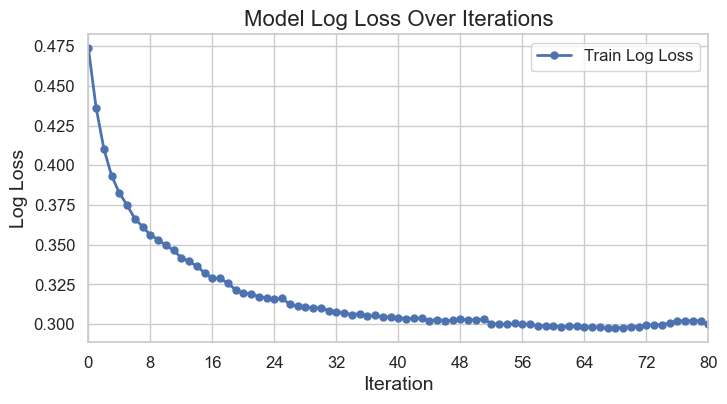

In [74]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(8, 4))

# Assuming you have the training history from your XGBoost model run
# Replace 'xgb_history' with the actual variable name that stores the training history
xgb_history = xgb_model.evals_result()

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(xgb_history['validation_0']['logloss'], label='Train Log Loss', linewidth=2, marker='o', markersize=5)

# Title and labels
plt.title('Model Log Loss Over Iterations', fontsize=16)
plt.ylabel('Log Loss', fontsize=14)
plt.xlabel('Iteration', fontsize=14)

# Legend
plt.legend(loc='upper right', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(xgb_history['validation_0']['logloss']) - 1)
plt.xticks(range(0, len(xgb_history['validation_0']['logloss']), max(len(xgb_history['validation_0']['logloss']) // 10, 1)), fontsize=12)
plt.yticks(fontsize=12);

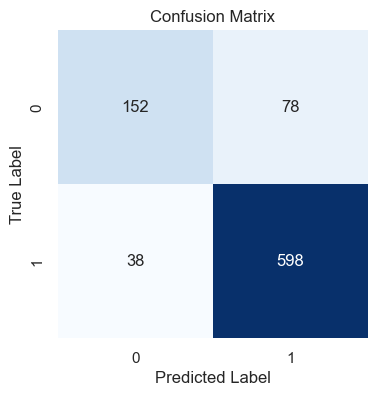

In [75]:
# Plotting the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

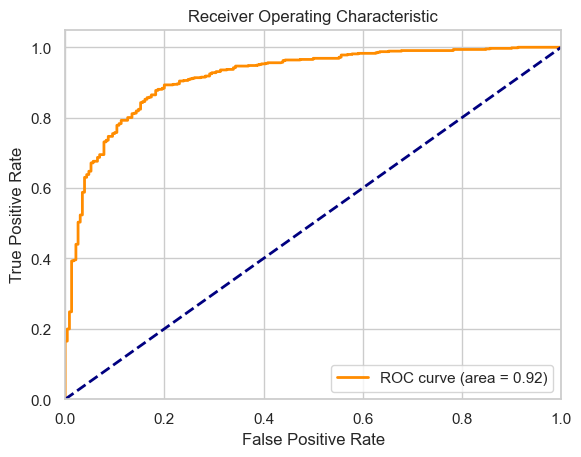

In [76]:


plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

In [77]:
# Save the XGBoost model to a binary file
xgb_model.save_model("saved_models/XGBoost_model.bin")